In [216]:
import cv2 
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt 
import numpy as np
import numpy as pynum_float
from scipy import spatial
import mahotas 
import math
from scipy.spatial import distance

Image Shape: (486, 729, 3)
Red Channel (486, 729)


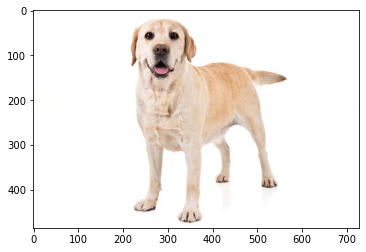

In [217]:
#Reading Image

# I = mpimg.imread('Hist_Image.jpg')  
I = mpimg.imread('Image8.jpg')
plt.imshow(I) 
print("Image Shape:",I.shape)

R=I[:,:,0]
G=I[:,:,1]
B=I[:,:,2]
print("Red Channel",R.shape)

In [218]:
#Creating bins per channel

bin_per_channel=pynum_float.arange(10.5,255,21) # 0-21,22-42,43-64,...234-255.
print("Bins:",bin_per_channel)
# print(len(bin_per_channel))


#Centroid for each bin or Total colour brought down from 256^3 to 1728
centroids={} # storing centroids of each bin
t=0
for i in range(0,12):
    for j in range(0,12):
        for k in range(0,12):
            t=t+1
            temp=[]
            temp.append(bin_per_channel[i])
            temp.append(bin_per_channel[j])
            temp.append(bin_per_channel[k])
#             temp=[bin_per_channel[i],bin_per_channel[j],bin_per_channel[k]]
            centroids[t]=temp
print("Example of Centroid:",centroids[11])
print("No of centroid:",len(centroids))

Bins: [ 10.5  31.5  52.5  73.5  94.5 115.5 136.5 157.5 178.5 199.5 220.5 241.5]
Example of Centroid: [10.5, 10.5, 220.5]
No of centroid: 1728


In [219]:
#Creating color histogram based on 1728 bins/colours
H={}
for i in range(0,len(I)):
    for j in range(0,len(I[0])):
        r=max((1,math.ceil(R[i][j]/22)))
        g=max((1,math.ceil(G[i][j]/22)))
        b=max((1,math.ceil(B[i][j]/22)))
        hi=144*(r-1)+12*(g-1)+b
        if(hi in H):
            H[hi]=H[hi]+1
        else:
            H[hi]=1
print(len(H))

157


In [220]:
sum(H.values())

354294

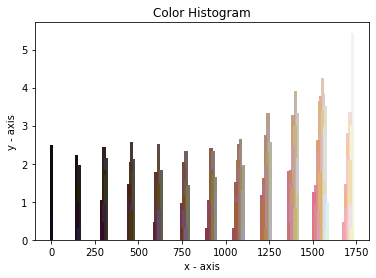

In [225]:
def plotting(X,Y,c):
    plt.bar(X, Y,color=c,width=20)
    plt.xlabel('x - axis') 
    plt.ylabel('y - axis') 
    plt.title('Color Histogram') 
    plt.show() 
    
#Plotting Histogram

c=list()
for key,values in H.items():
    temp=centroids[key]
    temp=[i/255 for i in temp]
    c.append(temp)
X=list(H.keys())
# Y=list(H.values())
Y=[math.log(y,10) for y in H.values()]
plotting(X,Y,c)

In [226]:
#Top 85 colours bins
H={k: v for k, v in sorted(H.items(), key=lambda item: item[1],reverse=True)}
H_85 = dict(list(H.items())[0: 85]) 
H_res=dict(list(H.items())[85: :])
print(H_85.values())

dict_values([276428, 17424, 8127, 6976, 6117, 4321, 3186, 2961, 2578, 2288, 2158, 2103, 1848, 1695, 1235, 1023, 990, 913, 908, 648, 588, 562, 456, 431, 376, 368, 325, 324, 313, 311, 291, 268, 260, 254, 254, 249, 218, 216, 212, 212, 190, 171, 170, 149, 141, 138, 132, 124, 123, 114, 111, 95, 93, 93, 80, 78, 74, 72, 69, 68, 67, 64, 63, 62, 61, 60, 59, 52, 52, 51, 47, 45, 41, 38, 33, 33, 32, 32, 31, 30, 30, 28, 28, 27, 26])


In [227]:
#Allocating remaining colours to the closest bins
temp=dict() # to store all pixels to which rest 85 are to be compared
for key,value in H_85.items():
    lab_color = color.rgb2lab([[centroids[key]]]) #RGB to Lab space
    temp[tuple(lab_color[0][0])]=key #stores Lab values for a given RGB of H_85


vector=[list(i) for i in temp.keys()] # vector of all centroids of bins in 85 in Lab
mapping=dict()# which bins mapped to which bins
for key,value in H_res.items():
    pixel=color.rgb2lab([[centroids[key]]])[0][0]
    tree = spatial.KDTree(vector)
    res=vector[tree.query(pixel)[1]]
    H_85[temp[tuple(res)]]+=value
    mapping[key]=temp[tuple(res)]

(486, 729, 3)


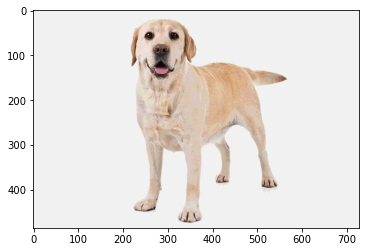

In [228]:
# Reading image from using just 85 Colours

temp_I=[]
for i in range(0,len(I)):
    for j in range(0,len(I[0])):
        r=max((1,math.ceil(R[i][j]/22)))
        g=max((1,math.ceil(G[i][j]/22)))
        b=max((1,math.ceil(B[i][j]/22)))
        hi=144*(r-1)+12*(g-1)+b
        if(hi in H_85):
            a=centroids[hi]
        else:
            a=centroids[mapping[hi]]
        temp=[i/255 for i in a]
        temp_I.append(temp)

temp_I=np.array((temp_I)).reshape(len(I),len(I[0]),3)
print(temp_I.shape)
plt.imshow(temp_I) 

In [229]:
# Saliency Calculation for each color 


#calcluating saliency Value
S={}
temp={}
for key,value in H_85.items():
    pixel_source=color.rgb2lab([[centroids[key]]])[0][0] 
    for key_,value_ in H_85.items():
        if(key_!=key):
            pixel_target=color.rgb2lab([[centroids[key_]]])[0][0]
            d = distance.euclidean(pixel_source,pixel_target)# Eulcidean distance for color distnace metric
            if(key in S):
                S[key]+=d*value_
            else:
                S[key]=d*value_
            
            if(key in temp):
                temp[key][key_]=d
            else:
                temp[key]={}
                temp[key][key_]=d

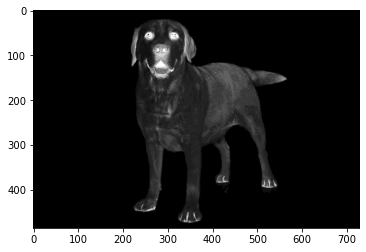

In [230]:
#Salinecy for each pixel and Display without smoothing code
S2 = [ [ 0 for i in range(len(I[0])) ] for j in range(len(I)) ]
for i in range(0,len(I)):
    for j in range(0,len(I[0])):
        r=max((1,math.ceil(R[i][j]/22)))
        g=max((1,math.ceil(G[i][j]/22)))
        b=max((1,math.ceil(B[i][j]/22)))
        hi=144*(r-1)+12*(g-1)+b
        if(hi in S):
            S2[i][j]=S[hi]
        else:
            S2[i][j]=S[mapping[hi]]
    
plt.imshow(S2,cmap='gray') 

In [231]:
# Smoothing saliency for each color
                
m=int(85/4)
S1={}
for key,value in H_85.items():
    temp_=temp[key]
    temp_={k: v for k, v in sorted(temp_.items(), key=lambda item: item[1])} #sorting to get the neares neighbours, item[1][1] for sorting second element basis
#     if(len(temp_)>m):
    temp_= dict(list(temp_.items())[0: m]) 
    T=0
    for key_,value_ in temp_.items():
        T+=value_
    for key_,value_ in temp_.items():
        if(key in S1):
            S1[key]+=((T-value_)*S[key_])
        else:
            S1[key]=((T-value_)*S[key_])
    S1[key]/=((m-1)*T)

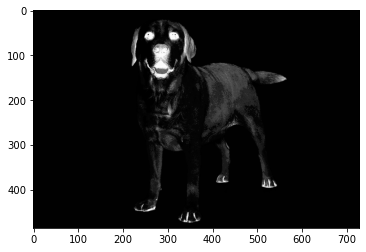

In [232]:
#Salinecy for each pixel and Display without smoothing code
S2 = [ [ 0 for i in range(len(I[0])) ] for j in range(len(I)) ]
temp={} # for storing m neighbours
for i in range(0,len(I)):
    for j in range(0,len(I[0])):
        r=max((1,math.ceil(R[i][j]/22)))
        g=max((1,math.ceil(G[i][j]/22)))
        b=max((1,math.ceil(B[i][j]/22)))
        hi=144*(r-1)+12*(g-1)+b
        if(hi in S1):
            S2[i][j]=S1[hi]
        else:
            S2[i][j]=S1[mapping[hi]]
    
plt.imshow(S2,cmap='gray') 

In [255]:
# a=1000000000*np.array(S2)
# a=np.array(a)+100000
# a=np.log(a)
# print(a.shape)
# plt.imshow(a,cmap='gray') 

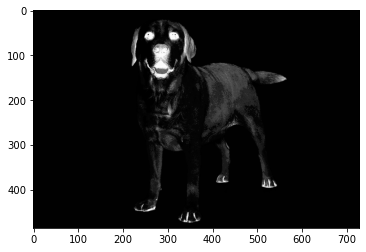

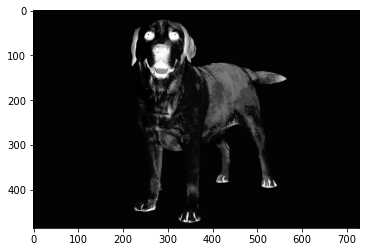

In [265]:
#Brightening of image Method 1
# a=1000000000*np.array(S2)
# a=np.array(a)+100000
# a=np.log(a)
# print(a.shape)
# plt.imshow(a,cmap='gray') 


#Brightening of image Method 2
image = S2
plt.imshow(image,cmap='gray') 

c = 255 / np.log(1 + np.max(image)) 
# log_image = c * (np.log(np.array(image) + 1)) 
log_image = np.log(np.array(image)*100 + 1)
log_image = np.array(log_image, dtype = np.uint8) 

# Display both images 
plt.imshow(image,cmap='gray') 
plt.show() 
plt.imshow(log_image,cmap='gray') 
plt.show() 


# ROUGH

In [24]:
# # Saliency Calculation for each color
# S={}
# temp={}
# for key,value in H.items():
#     for key_,value_ in H.items():
#         if(key_!=key):
#             d = distance.euclidean(centroids[key], centroids[key_])# Eulcidean distance for color distnace metric
#             if(key in S):
#                 S[key]+=d*value_
#             else:
#                 S[key]=d*value_
# #             if(coordinate in temp):
# #                 temp[coordinate][key]=d
# #             else:
# #                 temp[coordinate]={}
# #                 temp[coordinate][key]=d

In [25]:
# #Saliency Calculation
# S1 = [ [ 0 for i in range(len(I[0])) ] for j in range(len(I)) ]
# temp={} # for storing m neighbours
# for i in range(0,len(I)):
#     for j in range(0,len(I[0])):
#         r=max((1,math.ceil(R[i][j]%13)))
#         g=max((1,math.ceil(G[i][j]%13)))
#         b=max((1,math.ceil(B[i][j]%13)))
#         hi=144*(r-1)+12*(g-1)+b
#         S1[i][j]=S[hi]

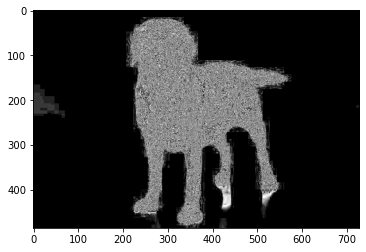

In [26]:
# plt.imshow(S1,cmap='gray') 
# #plt.imshow(image2np(S1.data))

In [41]:
# # Saliency Calculation for each color with smottinihg factor
# S={}
# temp={}
# for key,value in H.items():
#     for key_,value_ in H.items():
#         if(key_!=key):
#             d = distance.euclidean(centroids[key], centroids[key_])# Eulcidean distance for color distnace metric
#             if(key in S):
#                 S[key]+=d*value_
#             else:
#                 S[key]=d*value_
#             if(key in temp):
#                 temp[key][key_]=d
#             else:
#                 temp[key]={}
#                 temp[key][key_]=d
                
# m=int(1728/4)
# S1={}
# for key,value in H.items():
#     temp_=temp[key]
#     temp_={k: v for k, v in sorted(temp_.items(), key=lambda item: item[1])} #sorting to get the neares neighbours, item[1][1] for sorting second element basis
#     if(len(temp_)>m):
#         temp_= dict(list(temp_.items())[0: m]) 
#     T=0
#     for key,value in temp_.items():
#         T+=value
#     for key,value in temp_.items():
#         S1[key]=((T-value)*S[key])
#     S1[key]/=((m-1)*T)

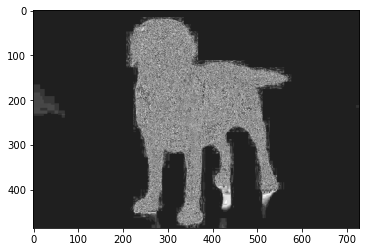

In [42]:
# #Saliency Calculation each pixel for 
# S2 = [ [ 0 for i in range(len(I[0])) ] for j in range(len(I)) ]
# temp={} # for storing m neighbours
# for i in range(0,len(I)):
#     for j in range(0,len(I[0])):
#         r=max((1,math.ceil(R[i][j]%13)))
#         g=max((1,math.ceil(G[i][j]%13)))
#         b=max((1,math.ceil(B[i][j]%13)))
#         hi=144*(r-1)+12*(g-1)+b
#         S2[i][j]=S1[hi]
    
# plt.imshow(S2,cmap='gray') 

In [27]:
# #Saliency Calculation
# S = [ [ 0 for i in range(len(I[0])) ] for j in range(len(I)) ]
# temp={} # for storing m neighbours
# for i in range(0,len(I)):
#     for j in range(0,len(I[0])):
#         r=max((1,math.ceil(R[i][j]%13)))
#         g=max((1,math.ceil(G[i][j]%13)))
#         b=max((1,math.ceil(B[i][j]%13)))
#         hi=144*(r-1)+12*(g-1)+b
#         pixel_bin=centroids[hi]
#         coordinate=tuple([i,j])
#         for key,value in H.items():
#             if(hi!=key):
#                 d = distance.euclidean(centroids[hi], centroids[key])# Eulcidean distance for color distnace metric
#                 S[i][j]+=d*value
#                 if(coordinate in temp):
#                     temp[coordinate][key]=d
#                 else:
#                     temp[coordinate]={}
#                     temp[coordinate][key]=d

In [14]:
#Smoothing factor
S_final=[ [ 0 for i in range(len(I[0])) ] for j in range(len(I)) ]
m=int(85/4)
for i in range(0,len(I)):
    for j in range(0,len(I[0])):
        r=max((1,math.ceil(R[i][j]%13)))
        g=max((1,math.ceil(G[i][j]%13)))
        b=max((1,math.ceil(B[i][j]%13)))
        hi=144*(r-1)+12*(g-1)+b
        pixel_bin=centroids[hi]
        coordinate=tuple([i,j])
        temp_=temp[coordinate]
        temp_={k: v for k, v in sorted(temp_.items(), key=lambda item: item[1])}
        temp_= dict(list(temp_.items())[0: m])  
        T=0
        for key,value in temp_.items():
            T+=value
        for key,value in temp_.items():
            S_final[i][j]+=(T-value)*S[key]
        S_final[i][j]/=(m-1)

IndexError: list index out of range

In [ ]:

# m=int(85/4)
# S_final=[ [ 0 for i in range(len(I[0])) ] for j in range(len(I)) ]
# for i in range(0,len(I)):
#     for j in range(0,len(I[0])):
#         r=max((1,math.ceil(R[i][j]%13)))
#         g=max((1,math.ceil(G[i][j]%13)))
#         b=max((1,math.ceil(B[i][j]%13)))
#         hi=144*(r-1)+12*(g-1)+b
#         c1=centroids[hi]
#         temp={}
#         for key,value in H.items():
#             if(hi!=key):
#                 temp[key]=distance.euclidean(centroids[hi], centroids[key])
#         temp={k: v for k, v in sorted(H.items(), key=lambda item: item[1],reverse=True)}
#         temp = dict(list(H.items())[0: m])  
#         T=0
#         for key,value in temp.items():
#             T+=value
#         for key,value in temp.items():
#             if(key!=hi):
#                 S_final[i][j]+=(T-value)*S[key]
#         S_final[i][j]/=(m-1)